<a href="https://colab.research.google.com/github/jrauf/Impact-of-News-Announcements-on-Stock-Price-and-Volume-Spikes-/blob/main/Newsandspikes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Impact of News Announcements on Stock Price and Volume Spikes**

Citation:

@misc{dong2024fnspid,
  title={FNSPID: A Comprehensive Financial News Dataset in Time Series},
  author={Zihan Dong and Xinyu Fan and Zhiyuan Peng},
  year={2024},
  eprint={2402.06698},
  archivePrefix={arXiv},
  primaryClass={q-fin.ST}
}

In [ ]:
!pip install gdown

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import math

import datetime
from scipy import stats
from scipy.stats import fisher_exact
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest

In [ ]:
# Run this to download the historical option data
# If you already have have the zip downloaded you can extract it to the same
# Directory "/content/Data" on google colab
file_url = 'https://drive.google.com/uc?id=1kvRqUf5OU7QMl9XaacxNFAqAndA6JgX3'

!gdown {file_url} --output "Historical_Option_Data.zip"

import zipfile
with zipfile.ZipFile("Historical_Option_Data.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/Data")

Downloading...
From (original): https://drive.google.com/uc?id=1kvRqUf5OU7QMl9XaacxNFAqAndA6JgX3
From (redirected): https://drive.google.com/uc?id=1kvRqUf5OU7QMl9XaacxNFAqAndA6JgX3&confirm=t&uuid=98158422-cd00-48d7-a215-e11bc6ca5af4
To: /content/Historical_Option_Data.zip
100% 1.49G/1.49G [00:14<00:00, 104MB/s]


In [ ]:
import os

file_id = '1b6e5FM3c9BHRzibuVr5uxKorBC3nh4An'
file_url = f'https://drive.google.com/uc?id={file_id}'
output_filename = 'nasdaq_external_data.csv'

# Download the file
print("Downloading nasdaq_external_data.csv...")
!gdown {file_url} --output "{output_filename}" --quiet

if os.path.exists(output_filename):
    print(f"Successfully downloaded {output_filename}")
else:
    print(f"Failed to download {output_filename}. Please check the file ID and permissions.")

# Extract
if output_filename.endswith('.zip'):
    extract_path = "Data"
    os.makedirs(extract_path, exist_ok=True)

    with zipfile.ZipFile(output_filename, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    extracted_file_path = os.path.join(extract_path, 'nasdaq_external_data.csv')
    print(f"Extracted CSV to {extracted_file_path}")
else:
    extracted_file_path = output_filename  # Direct CSV


columns_to_extract = ['Date', 'Article_title', 'Stock_symbol']
chunksize = 10**6
data_frames = []

print("Reading and filtering the CSV file...")
for chunk_number, chunk in enumerate(pd.read_csv(extracted_file_path, usecols=columns_to_extract, chunksize=chunksize)):
    print(f"Processing chunk {chunk_number + 1}")
    data_frames.append(chunk)

filtered_data = pd.concat(data_frames, ignore_index=True)
print("Finished reading and filtering the data.")

# Data Cleaning
Print("Cleaning data...")
initial_shape = filtered_data.shape
filtered_data.drop_duplicates(inplace=True)
final_shape = filtered_data.shape
print(f"Dropped {initial_shape[0] - final_shape[0]} duplicate rows.")

filtered_data.dropna(subset=columns_to_extract, inplace=True)

# Verify
print("First 5 rows of the filtered data:")
print(filtered_data.head())

print("\nDataFrame Information:")
print(filtered_data.info())

# **Only Run if above cell limits you, downloaded file is required**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/isye 3030/nasdaq_external_data.csv'

columns_to_extract = ['Date', 'Article_title', 'Stock_symbol']
chunksize = 10**6
data_frames = []

for chunk in pd.read_csv(file_path, usecols=columns_to_extract, chunksize=chunksize):
    data_frames.append(chunk)

# Combine all chunks into a single DataFrame
filtered_data = pd.concat(data_frames, ignore_index=True)

filtered_data.drop

print(filtered_data.head())

# **Input Stock Ticker**

In [ ]:
ticker = input("Ticker:")

Ticker:AMZN


In [ ]:
file_path = f"/content/Data/Historical Option Data/{ticker}_options_data.csv"
optionsdf = pd.read_csv(file_path)
optionsdf

,ticker,volume,open,close,high,low,window_start,transactions,underlying_ticker,expiration_date,option_type,strike_price,underlying_ticker_base
0,O:AMZN221118C00050000,4,46.75,46.40,46.75,46.25,2022-11-16 05:00:00,4,AMZNC,2022-11-18,Put,50.0,AMZN
1,O:AMZN221118C00052000,1,44.30,44.30,44.30,44.30,2022-11-16 05:00:00,1,AMZNC,2022-11-18,Put,52.0,AMZN
2,O:AMZN221118C00070000,6,27.75,27.47,27.75,27.46,2022-11-16 05:00:00,5,AMZNC,2022-11-18,Put,70.0,AMZN
3,O:AMZN221118C00073000,16,23.30,23.30,23.30,23.30,2022-11-16 05:00:00,3,AMZNC,2022-11-18,Put,73.0,AMZN
4,O:AMZN221118C00077000,8,18.92,18.92,18.92,18.92,2022-11-16 05:00:00,4,AMZNC,2022-11-18,Put,77.0,AMZN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
624058,O:AMZN270115P00140000,1,10.35,10.35,10.35,10.35,2024-10-09 04:00:00,1,AMZN,2027-01-15,Put,140.0,AMZN
624059,O:AMZN270115P00175000,4,23.70,23.05,23.80,23.05,2024-10-09 04:00:00,3,AMZN,2027-01-15,Put,175.0,AMZN
624060,O:AMZN270115P00180000,201,26.20,26.15,26.20,26.15,2024-10-09 04:00:00,6,AMZN,2027-01-15,Put,180.0,AMZN
624061,O:AMZN270115P00185000,3,27.90,27.55,27.90,27.55,2024-10-09 04:00:00,2,AMZN,2027-01-15,Put,185.0,AMZN


In [ ]:
optionsdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 624063 entries, 0 to 624062
Data columns (total 13 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   ticker                  624063 non-null  object 
 1   volume                  624063 non-null  int64  
 2   open                    624063 non-null  float64
 3   close                   624063 non-null  float64
 4   high                    624063 non-null  float64
 5   low                     624063 non-null  float64
 6   window_start            624063 non-null  object 
 7   transactions            624063 non-null  int64  
 8   underlying_ticker       624063 non-null  object 
 9   expiration_date         624063 non-null  object 
 10  option_type             624063 non-null  object 
 11  strike_price            624063 non-null  float64
 12  underlying_ticker_base  624063 non-null  object 
dtypes: float64(5), int64(2), object(6)
memory usage: 61.9+ MB


# **Retrieve Stock Data**

ALL uses of 'stockdf' are referencing the stock dataframe that is filtered by ticker, therefore there is no 'stockdf_filtered' as one might expect in light of there being a 'newsdf' and 'newsdf_filtered'.

In [ ]:
#currently lookinga at at past 30 days edit end and start date to change
endDate = datetime.date.today()
years = 2
startDate = endDate - datetime.timedelta(days=365 * years) # 2 years
stockdf = yf.download(ticker, startDate, endDate)
stockdf

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AMZN,AMZN,AMZN,AMZN,AMZN,AMZN
Date,,,,,,
2022-12-08,90.349998,90.349998,90.860001,87.879997,89.239998,73305900
2022-12-09,89.089996,89.089996,90.300003,88.629997,88.900002,67398500
2022-12-12,90.550003,90.550003,90.580002,87.870003,89.209999,61999800
2022-12-13,92.489998,92.489998,96.250000,90.519997,95.230003,100212000
2022-12-14,91.580002,91.580002,93.459999,89.870003,92.500000,70298000
...,...,...,...,...,...,...
2024-12-02,210.710007,210.710007,212.990005,209.509995,209.960007,39523200
2024-12-03,213.440002,213.440002,214.020004,209.649994,210.309998,32214800


# **Retrieve News Data**

In [ ]:
years = 3 #data until 3 years ago

# Convert 'Date' column to datetime objects
filtered_data['Date'] = pd.to_datetime(filtered_data['Date']).dt.date

# Filter data
newsdf = filtered_data[filtered_data['Date'] >= (datetime.date.today() - datetime.timedelta(days=365 * years))]

# Filter `newsdf` where 'Stock_symbol' matches the `ticker` variable
newsdf_filtered = newsdf.loc[newsdf['Stock_symbol'] == ticker]

newsdf_filtered['date'] = pd.to_datetime(newsdf['Date']).dt.normalize()

#If less than required_news amount of news, dont use ticker
required_news = 1000

if newsdf_filtered.size < required_news:
  print(f"{ticker} has less than {required_news} news data, use another ticker.")

else:
  # Display the first few rows of the filtered DataFrame
  newsdf_filtered.head()

<ipython-input-34-120a98692778>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newsdf_filtered['date'] = pd.to_datetime(newsdf['Date']).dt.normalize()


# **Analysis**
**The below code runs fully with the input of a ticker of your selection**

<ipython-input-35-9be698a08948>:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  newsdf_filtered['date'] = pd.to_datetime(newsdf_filtered['date']).dt.date


------------------------------------------------------------------------------------------------------------------------------------------
Question 1: Do unusual trading activities align with public news announcements?
------------------------------------------------------------------------------------------------------------------------------------------

Volume Spike vs. News Contingency Table:
news          False  True 
volume_spike              
False           293    182
True             17     10

Chi-squared test for volume spikes vs. news: chi2=0.0000, p-value=1.0000

Price Spike vs. News Contingency Table:
news         False  True 
price_spike              
False          294    185
True            16      7

Chi-squared test for price spikes vs. news: chi2=0.3244, p-value=0.5689
------------------------------------------------------------------------------------------------------------------------------------------
Question 2: Is there a statistically significant relationship

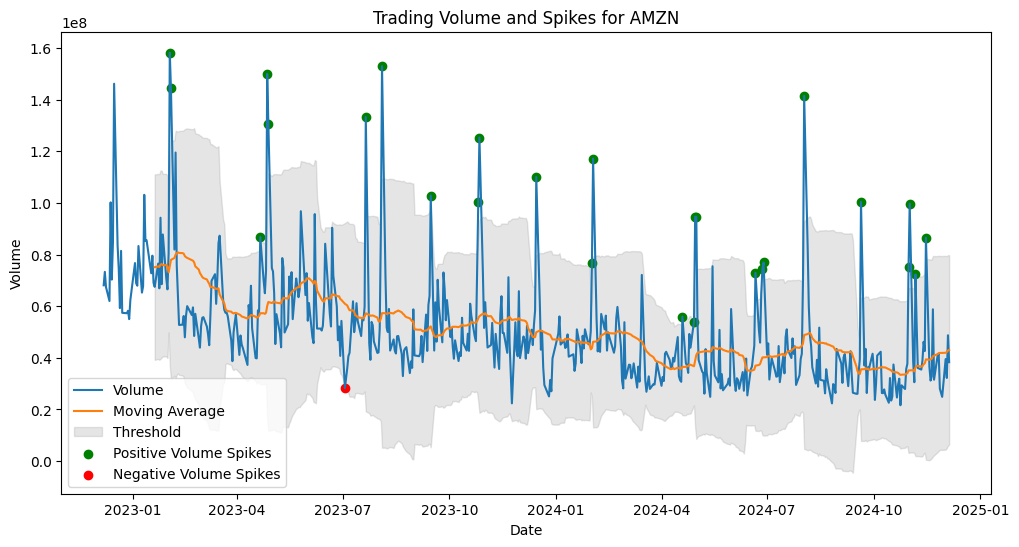

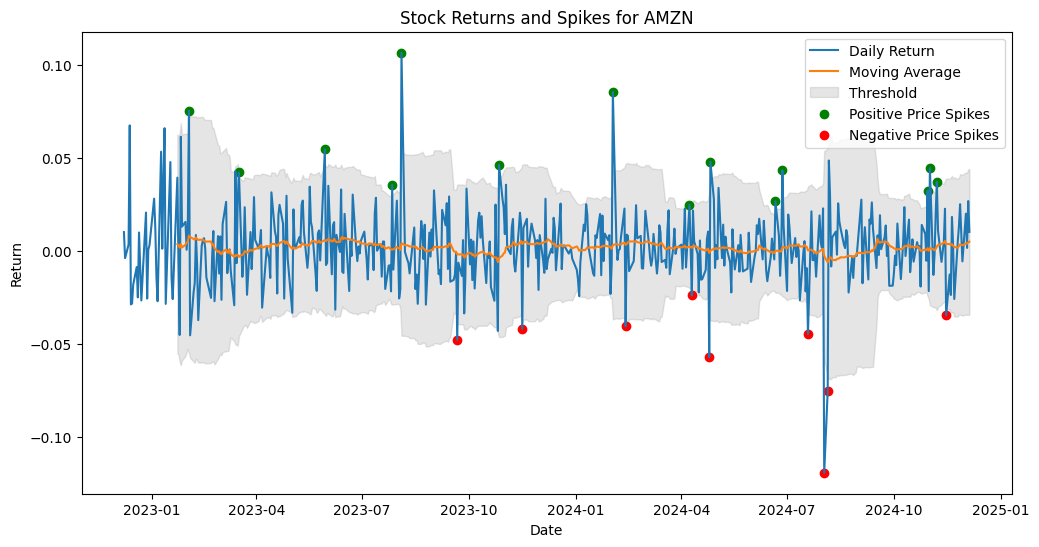

In [ ]:
# Ensure 'stockdf' index is datetime and set to date only (remove time)
stockdf.index = pd.to_datetime(stockdf.index)
stockdf.index = stockdf.index.tz_localize(None)
stockdf.index = stockdf.index.date  # Convert index to date only

# Filter 'stockdf' for the specific ticker if necessary
# Since 'stockdf' has a MultiIndex, we need to select the columns for the ticker
stockdf_ticker = stockdf.xs(ticker, level='Ticker', axis=1)

# Since stockdf has a single level column index, directly rename columns
stockdf.columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

# Prepare the stock data
stock_data = stockdf.copy()
stock_data['Date'] = stock_data.index

# Calculate daily returns and volume
stock_data['Return'] = stock_data['Adj Close'].pct_change()
stock_data['Volume'] = stock_data['Volume']  # Volume is already present

# Reset index to 'Date'
stock_data.set_index('Date', inplace=True)

# Step 1: Identifying Unusual Stock Trading Activity

# Define the window size for moving average and standard deviation
window_size = 30  # days

# Calculate moving average and standard deviation for volume
stock_data['volume_ma'] = stock_data['Volume'].rolling(window=window_size).mean()
stock_data['volume_std'] = stock_data['Volume'].rolling(window=window_size).std()

# Set threshold for detecting volume spikes
threshold = 2  # Number of standard deviations

# Detect positive volume spikes (spikes up)
stock_data['volume_spike_up'] = (stock_data['Volume'] > stock_data['volume_ma'] + threshold * stock_data['volume_std'])

# Detect negative volume spikes (spikes down)
stock_data['volume_spike_down'] = (stock_data['Volume'] < stock_data['volume_ma'] - threshold * stock_data['volume_std'])

# Combine both positive and negative volume spikes
stock_data['volume_spike'] = stock_data['volume_spike_up'] | stock_data['volume_spike_down']

# Calculate moving average and standard deviation for returns
stock_data['return_ma'] = stock_data['Return'].rolling(window=window_size).mean()
stock_data['return_std'] = stock_data['Return'].rolling(window=window_size).std()

# Detect positive price spikes (spikes up)
stock_data['price_spike_up'] = (stock_data['Return'] > stock_data['return_ma'] + threshold * stock_data['return_std'])

# Detect negative price spikes (spikes down)
stock_data['price_spike_down'] = (stock_data['Return'] < stock_data['return_ma'] - threshold * stock_data['return_std'])

# Combine both positive and negative price spikes
stock_data['price_spike'] = stock_data['price_spike_up'] | stock_data['price_spike_down']

# Remove rows with NaN values resulting from rolling calculations
stock_data.dropna(subset=['volume_spike', 'price_spike'], inplace=True)

# Step 2: Aligning Unusual Activity with Public News Announcements

# Ensure 'date' column in 'newsdf' is datetime.date
newsdf_filtered['date'] = pd.to_datetime(newsdf_filtered['date']).dt.date

# Create 'news' indicator in stock_data
news_dates = newsdf_filtered['date'].unique()
stock_data['news'] = stock_data.index.isin(news_dates)

# Step 3: Statistical Analysis

# Create 'unexplained' spike columns (spikes without accompanying news)
stock_data['unexplained_volume_spike'] = stock_data['volume_spike'] & (~stock_data['news'])
stock_data['unexplained_price_spike'] = stock_data['price_spike'] & (~stock_data['news'])

print("------------------------------------------------------------------------------------------------------------------------------------------\nQuestion 1: Do unusual trading activities align with public news announcements?\n------------------------------------------------------------------------------------------------------------------------------------------")

# For volume spikes
volume_spike_counts = pd.crosstab(stock_data['volume_spike'], stock_data['news'])
print("\nVolume Spike vs. News Contingency Table:")
print(volume_spike_counts)

# Chi-squared test for volume spikes
if volume_spike_counts.shape == (2, 2):
    chi2_vol, p_vol, dof_vol, expected_vol = stats.chi2_contingency(volume_spike_counts)
    print(f"\nChi-squared test for volume spikes vs. news: chi2={chi2_vol:.4f}, p-value={p_vol:.4f}")
else:
    print("\nNot enough data for chi-squared test for volume spikes.")

# For price spikes
price_spike_counts = pd.crosstab(stock_data['price_spike'], stock_data['news'])
print("\nPrice Spike vs. News Contingency Table:")
print(price_spike_counts)

# Chi-squared test for price spikes
if price_spike_counts.shape == (2, 2):
    chi2_price, p_price, dof_price, expected_price = stats.chi2_contingency(price_spike_counts)
    print(f"\nChi-squared test for price spikes vs. news: chi2={chi2_price:.4f}, p-value={p_price:.4f}")
else:
    print("\nNot enough data for chi-squared test for price spikes.")

print("------------------------------------------------------------------------------------------------------------------------------------------\nQuestion 2: Is there a statistically significant relationship between spikes and the presence/absence of news events?\n------------------------------------------------------------------------------------------------------------------------------------------")

# Logistic Regression for volume spikes
logit_data_vol = stock_data[['volume_spike', 'news']].dropna()
logit_data_vol['intercept'] = 1

if logit_data_vol['volume_spike'].nunique() > 1 and logit_data_vol['news'].nunique() > 1:
    logit_model_vol = sm.Logit(logit_data_vol['volume_spike'].astype(int), logit_data_vol[['intercept', 'news']].astype(int))
    result_vol = logit_model_vol.fit(disp=False)
    print("\nLogistic Regression Results for Volume Spikes:")
    print(result_vol.summary())
else:
    print("\nNot enough variation in data for logistic regression on volume spikes.")

# Logistic Regression for price spikes
logit_data_price = stock_data[['price_spike', 'news']].dropna()
logit_data_price['intercept'] = 1

if logit_data_price['price_spike'].nunique() > 1 and logit_data_price['news'].nunique() > 1:
    logit_model_price = sm.Logit(logit_data_price['price_spike'].astype(int), logit_data_price[['intercept', 'news']].astype(int))
    result_price = logit_model_price.fit(disp=False)
    print("\nLogistic Regression Results for Price Spikes:")
    print(result_price.summary())
else:
    print("\nNot enough variation in data for logistic regression on price spikes.")

print("------------------------------------------------------------------------------------------------------------------------------------------\nQuestion 3: Are volume spikes or price spikes more likely to be unexplained by news events?\n------------------------------------------------------------------------------------------------------------------------------------------")

# Calculate proportions of unexplained spikes
total_days = len(stock_data)

volume_unexplained_spike_days = stock_data['unexplained_volume_spike'].sum()
price_unexplained_spike_days = stock_data['unexplained_price_spike'].sum()

volume_spike_proportion = volume_unexplained_spike_days / total_days
price_spike_proportion = price_unexplained_spike_days / total_days

print(f"\nVolume unexplained spike proportion: {volume_spike_proportion:.4f}")
print(f"Price unexplained spike proportion: {price_spike_proportion:.4f}")

# Z-test for proportions between volume and price unexplained spikes
count = np.array([volume_unexplained_spike_days, price_unexplained_spike_days])
nobs = np.array([total_days, total_days])

if volume_unexplained_spike_days + price_unexplained_spike_days > 0:
    stat, pval = proportions_ztest(count, nobs)
    print(f"\nProportions z-test between volume and price unexplained spikes: stat={stat:.4f}, p-value={pval:.4f}")
else:
    print("\nNot enough unexplained spikes for z-test.")

# Visualizations (optional)

# Plotting volume and spikes
plt.figure(figsize=(12,6))
plt.plot(stock_data.index, stock_data['Volume'], label='Volume')
plt.plot(stock_data.index, stock_data['volume_ma'], label='Moving Average')
plt.fill_between(stock_data.index, stock_data['volume_ma'] + threshold * stock_data['volume_std'], stock_data['volume_ma'] - threshold * stock_data['volume_std'], color='gray', alpha=0.2, label='Threshold')
plt.scatter(stock_data.index[stock_data['volume_spike_up']], stock_data['Volume'][stock_data['volume_spike_up']], color='green', label='Positive Volume Spikes')
plt.scatter(stock_data.index[stock_data['volume_spike_down']], stock_data['Volume'][stock_data['volume_spike_down']], color='red', label='Negative Volume Spikes')
plt.title(f"Trading Volume and Spikes for {ticker}")
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

# Plotting returns and spikes
plt.figure(figsize=(12,6))
plt.plot(stock_data.index, stock_data['Return'], label='Daily Return')
plt.plot(stock_data.index, stock_data['return_ma'], label='Moving Average')
plt.fill_between(stock_data.index, stock_data['return_ma'] + threshold * stock_data['return_std'], stock_data['return_ma'] - threshold * stock_data['return_std'], color='gray', alpha=0.2, label='Threshold')
plt.scatter(stock_data.index[stock_data['price_spike_up']], stock_data['Return'][stock_data['price_spike_up']], color='green', label='Positive Price Spikes')
plt.scatter(stock_data.index[stock_data['price_spike_down']], stock_data['Return'][stock_data['price_spike_down']], color='red', label='Negative Price Spikes')
plt.title(f"Stock Returns and Spikes for {ticker}")
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.show()